In [5]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM,Bidirectional,Conv1D,MaxPool1D,Dense,Input, Flatten,Dropout,SpatialDropout1D,GlobalMaxPool1D,concatenate
from keras.models import Sequential, Model
from keras import backend as K
from keras.utils import np_utils
import matplotlib.pyplot as plt
import gc
from keras import callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint

C:\Users\yangt\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
e_features = pd.read_csv('extracted_features.csv', index_col=0)
df = pd.read_csv('prepped_data.csv', index_col=0)

X = df[['postText', 'targetTitle','targetDescription', 'targetKeywords']].join(e_features)
X['postText'] = X['postText'].fillna('')
X['targetDescription'] = X['targetDescription'].fillna('')
X['targetKeywords'] = X['targetKeywords'].fillna('')
df['new_label']  = pd.cut(df['truthJudgments'].apply(lambda x: np.mean(eval(x))), [-1,0.33,0.66,1.01],labels =[0,1,2])
y = df['new_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

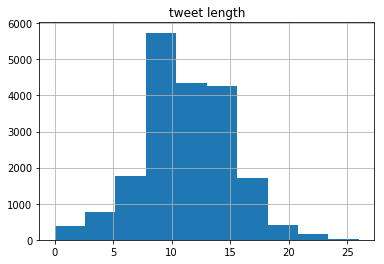

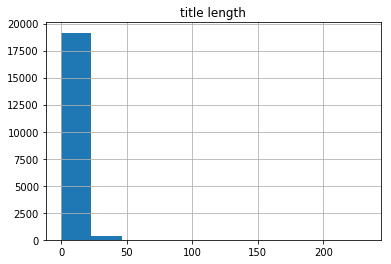

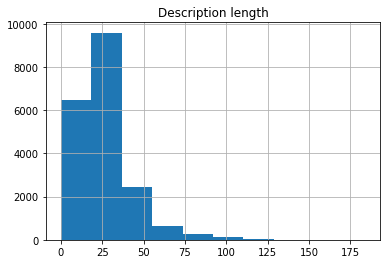

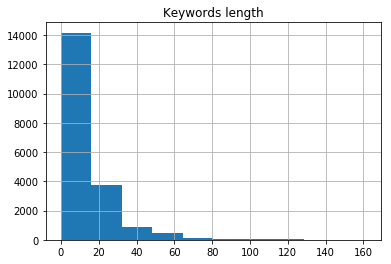

In [7]:
X['tw_length_in_word'].hist()
plt.title('tweet length')
plt.show()

X['ttl_length_in_word'].hist()
plt.title('title length')
plt.show()

X['targetDescription'].apply(lambda x: len(nltk.word_tokenize(x))).hist()
plt.title('Description length')
plt.show()

X['targetKeywords'].apply(lambda x:len(nltk.word_tokenize(x))).hist()
plt.title('Keywords length')
plt.show()

In [8]:
# Tokenize text fields 
# post, title, description, keywords
tw_maxlen = 25
title_maxlen =25
des_maxlen = 50
kw_maxlen =30
word_dimension = 300
max_vocabs = 100000

tw_tok =Tokenizer(lower = False,filters='!"#$%&()*+,-./\':;<=>?@[\\]^_`{|}~\t\n')
title_tok =Tokenizer(lower =False,filters='!"#$%&()*+,-./\':;<=>?@[\\]^_`{|}~\t\n')
des_tok = Tokenizer(lower = False,filters='!"#$%&()*+,-./\':;<=>?@[\\]^_`{|}~\t\n')
kw_tok =Tokenizer(lower = False,filters='!"#$%&()*+,-./\':;<=>?@[\\]^_`{|}~\t\n')

tw_tok.fit_on_texts(X_train['postText'])
title_tok.fit_on_texts(X_train['targetTitle'])
des_tok.fit_on_texts(X_train['targetDescription'])
kw_tok.fit_on_texts(X_train['targetKeywords'])

X_train_tw_tok = tw_tok.texts_to_sequences(X_train['postText'])
X_test_tw_tok = tw_tok.texts_to_sequences(X_test['postText'])
X_train_tw_tok = pad_sequences(X_train_tw_tok, maxlen = tw_maxlen)
X_test_tw_tok = pad_sequences(X_test_tw_tok,maxlen = tw_maxlen)

X_train_title_tok =title_tok.texts_to_sequences(X_train['targetTitle'])
X_test_title_tok = title_tok.texts_to_sequences(X_test['targetTitle'])
X_train_title_tok = pad_sequences(X_train_title_tok, maxlen = title_maxlen)
X_test_title_tok = pad_sequences(X_test_title_tok,maxlen = title_maxlen)

X_train_des_tok = des_tok.texts_to_sequences(X_train['targetDescription'])
X_test_des_tok = des_tok.texts_to_sequences(X_test['targetDescription'])
X_train_des_tok = pad_sequences(X_train_des_tok, maxlen = des_maxlen)
X_test_des_tok = pad_sequences(X_test_des_tok,maxlen = des_maxlen)


X_train_kw_tok = kw_tok.texts_to_sequences(X_train['targetDescription'])
X_test_kw_tok = kw_tok.texts_to_sequences(X_test['targetDescription'])
X_train_kw_tok = pad_sequences(X_train_kw_tok, maxlen = kw_maxlen)
X_test_kw_tok = pad_sequences(X_test_kw_tok,maxlen = kw_maxlen)


In [9]:
# get embedding 
embedding_index = {}
with open('C:/Users/yangt/Desktop/glove.42B.300d.txt',encoding='utf-8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

In [10]:
# construct embedding matrix for each text fields
def get_embedding_matrix(tokenizer,  max_vocabs,word_dimension, embedding_index):
    top_vocabs = dict(tokenizer.word_counts)
    top_vocabs = set(sorted(top_vocabs, key = top_vocabs.get, reverse=True)[:max_vocabs])
    word_map= dict((key, value) for key,value in tokenizer.word_index.items() if key in top_vocabs)
    em = np.random.uniform(size = (len(word_map)+1, word_dimension))
    not_found = 0
    for word,index in word_map.items():
        vec = embedding_index.get(word)
        if vec is not None:
            em[index] = vec
        else:
            not_found+=1
    not_found/len(word_map)
    return em,not_found/len(word_map)
tw_em,p = get_embedding_matrix(tw_tok,  max_vocabs,word_dimension, embedding_index)
print('tweets missing proportion: ', p)
title_em,p = get_embedding_matrix(title_tok,  max_vocabs,word_dimension, embedding_index)
print('title missing proportion: ', p)
des_em,p  = get_embedding_matrix(des_tok,  max_vocabs,word_dimension, embedding_index)
print('description missing proportion: ', p)
kw_em,p = get_embedding_matrix(kw_tok,  max_vocabs,word_dimension, embedding_index)
print('kw missing proportion: ', p)

# free memory
embedding_index =None
gc.collect()

tweets missing proportion:  0.4419629357639639
title missing proportion:  0.6435902881007999
description missing proportion:  0.4823322073725951
kw missing proportion:  0.4893747929386152


0

In [11]:
# construct model
embedding_train = True
tw_input=  Input(shape=(tw_maxlen,))
tw_layers  = Embedding(tw_em.shape[0],word_dimension ,input_length=tw_maxlen, weights = [tw_em], trainable  = embedding_train)(tw_input)
tw_layers = SpatialDropout1D(0.1)(tw_layers)
tw_layers = Bidirectional(LSTM(64, return_sequences=True, dropout =0.1, recurrent_dropout=0.1))(tw_layers)
tw_layers = GlobalMaxPool1D()(tw_layers)

tt_input =  Input(shape=(title_maxlen,))
tt_layers  = Embedding(title_em.shape[0],word_dimension , weights = [title_em], trainable  = embedding_train)(tt_input)
tt_layers = SpatialDropout1D(0.1)(tt_layers)
tt_layers = Bidirectional(LSTM(64, return_sequences=True, dropout =0.1, recurrent_dropout=0.1))(tt_layers)
tt_layers = GlobalMaxPool1D()(tt_layers)

des_input =  Input(shape=(des_maxlen,))
des_layers  = Embedding(des_em.shape[0],word_dimension , weights = [des_em], trainable  = embedding_train)(des_input)
des_layers = SpatialDropout1D(0.1)(des_layers)
des_layers = Bidirectional(LSTM(64, return_sequences=True, dropout =0.1, recurrent_dropout=0.1))(des_layers)
des_layers = GlobalMaxPool1D()(des_layers)

kw_input =  Input(shape=(kw_maxlen,))
kw_layers  = Embedding(kw_em.shape[0],word_dimension , weights = [kw_em], trainable  = embedding_train)(kw_input)
kw_layers = SpatialDropout1D(0.1)(kw_layers)
kw_layers = Bidirectional(LSTM(64, return_sequences=True, dropout =0.1, recurrent_dropout=0.1))(kw_layers)
kw_layers = GlobalMaxPool1D()(kw_layers)

ef_input =Input(shape=(X.shape[1]-4,))

merged = concatenate([tw_layers, tt_layers,des_layers, ef_input])
merged  = Dense(128, activation= 'relu')(merged)
merged = Dropout(0.3)(merged)
output = Dense(3, activation = 'softmax')(merged)

model = Model(inputs = [tw_input, tt_input, des_input, kw_input,ef_input], outputs = output)

model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 25, 300)      6945000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
               metrics=['accuracy'])
Y_train = np_utils.to_categorical(y_train, 3)

early = EarlyStopping(monitor="val_acc", mode="max", patience=1)

model.fit([X_train_tw_tok,X_train_title_tok,X_train_des_tok, X_train_kw_tok,X_train.iloc[:,4:]]
          , Y_train, epochs=15, batch_size=128, validation_split = 0.2,callbacks = [early])

Train on 12504 samples, validate on 3126 samples
Epoch 1/15
12504/12504 [==============================] - 27s 2ms/step - loss: 5.9801 - acc: 0.4640 - val_loss: 2.8407 - val_acc: 0.4990
Epoch 2/15
12504/12504 [==============================] - 25s 2ms/step - loss: 2.2521 - acc: 0.5340 - val_loss: 0.9449 - val_acc: 0.6254
Epoch 3/15
12504/12504 [==============================] - 25s 2ms/step - loss: 0.9614 - acc: 0.6208 - val_loss: 0.8564 - val_acc: 0.6225


In [14]:
y_pred = model.predict([X_test_tw_tok,X_test_title_tok,X_test_des_tok, X_test_kw_tok,X_test.iloc[:,4:]])

y_pred = np.argmax(y_pred,axis =1)

from sklearn.metrics import classification_report
with open('dlresult.txt','w+') as f:
    f.write(classification_report(y_test.values, y_pred,target_names=['Non Clickbaits', 'Maybe Clickbaits', 'Definite Clickbaits']))
